## Reduce RG Shifts
---

Concerned that swapping in the new model would significantly impact user experience. Let's take a look and see if we can mitigate such behavior by playing around with the fitted models.

#### Summary
---
* We take a look at the following methods to combine the `incumbent` and `refitted` model
    * linear interpolation by prediction - before scaling
    * linear interpolation by score 
    * minimum of the scores -> only allows rg improvements
    * maximum of the scores -> only allows rg reduction
        * 3,4 are not really fair tbh..
    * shrink the score shifts -> take a square root
    * reverse curving..see logic later
* results

|FIELD1      |auc  |ap   |pct_rg_unchanged  |
|------------|-----|-----|------------------|
|rg_incumbent|68.62|10.02|1.0               |
|reverse curving| 69.36 | 10.63 | 0.9812 |
|sqrt score shifts     |70.19|11.31|0.9477|
|max scores     |70.31|10.95|0.9289|
|linear interp - score     |74.12|14.98|0.8489|
|linear interp - pred     |73.67|12.88|0.8256|
|min scores     |77.02|18.15|0.7880  |
|rg_wo_ind (refitted)   |77.92|18.29|0.7169|

Looking at the trade of between `pct_rg_unchanged` and performances, it appears the better options are:
* linear interpolating scores: 15% rg shifts for +6 auc and +5 in ap
* sqrt score shifts: 5% rg shifts for +1.5 auc and +1.3 ap

Notice: 
* The linear interp methods produce a rather smooth tradeoff between rg shifts and improvements, so it is possible to manually select a cut-off. See plots below.

#### Threshold Optimization
At the end of this page we have some optimization methods to adjust risk group thresholds to minimum rg shift.

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
from smart_open import open

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"

# train_path = os.path.join(s3_base_path, "dev_train_scored.parquet")
test_path = os.path.join(s3_base_path, "dev_test_scored.parquet")
test_df = pd.read_parquet(test_path)
test_df = mu.preprocess(test_df)
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)

In [3]:
with open("../../artifacts/20210508-reduced-features/customer_risk_wo_ind.pkl", "rb") as f:
    clf_wo_ind = pkl.load(f)
    
prev_model_s3_key = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
with open(prev_model_s3_key, "rb") as f:
    incumbent_model = pkl.load(f)
    
test_df["pred_incumbent"] = incumbent_model.predict_proba(test_df[incumbent_model.feature_name_])[:,1]
test_df["pred_wo_ind"] = clf_wo_ind.predict_proba(test_df[clf_wo_ind.feature_name_])[:,1]

# get score
test_df["score_wo_ind"] = mu.scale_scores(test_df["pred_wo_ind"])
test_df["score_incumbent"] = mu.scale_scores(test_df["pred_incumbent"])

def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, include_lowest=True, labels=[f'RG{i}' for i in range(1, 6)])

# get risk groups
test_df['rg_incumbent'] = get_risk_groups(test_df.score_incumbent)
test_df['rg_wo_ind'] = get_risk_groups(test_df.score_wo_ind)

In [4]:
cols = ["business_account_number", "sample_date", "borrower_id", 
        "pred_incumbent", "score_incumbent", "rg_incumbent", 
        "pred_wo_ind", "score_wo_ind", "rg_wo_ind"]

### For 2021-01-01
---
#### Current best

In [5]:
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]

ratio of users kept their RG:  0.7169191193114037


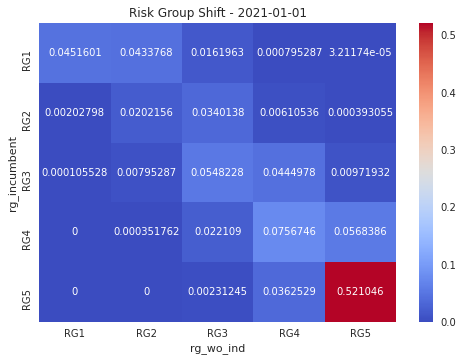

In [6]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_wo_ind"
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - 2021-01-01')

print("ratio of users kept their RG: ", np.trace(table))

#### Active-Inactive groups
---

We do see active users where impacted more by the refitted model.

In [7]:
df_ = test_df[(test_df.sample_date == pd.to_datetime("2021-01-01"))
              & (test_df.is_active)]

nr accounts:  107874
ratio of users kept their RG:  0.5734375289689824


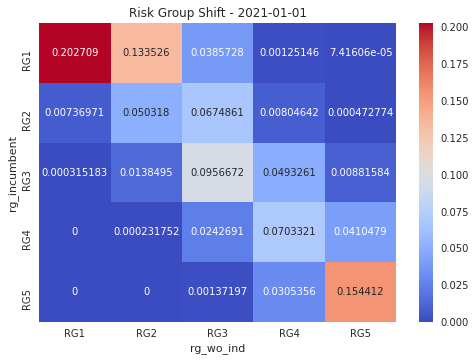

In [8]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_wo_ind"
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - 2021-01-01')

print("nr accounts: ", df_.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

In [9]:
df_ = test_df[(test_df.sample_date == pd.to_datetime("2021-01-01"))
              & (~test_df.is_active)]

nr accounts:  545978
ratio of users kept their RG:  0.745268124356659


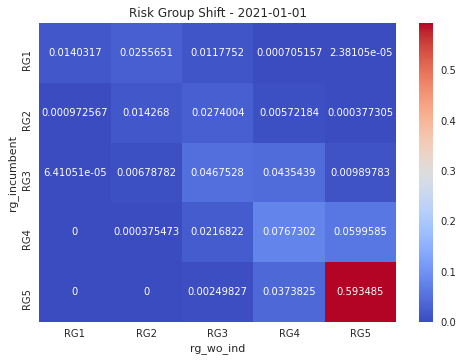

In [10]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_wo_ind"
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - 2021-01-01')

print("nr accounts: ", df_.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

#### Experiments
---

tools:

```python
# get score
test_df["score_wo_ind"] = mu.scale_scores(test_df["pred_wo_ind"])
test_df["score_incumbent"] = mu.scale_scores(test_df["pred_incumbent"])

# get risk groups
test_df['rg_incumbent'] = get_risk_groups(test_df.score_incumbent)
test_df['rg_wo_ind'] = get_risk_groups(test_df.score_wo_ind)
```

In [11]:
def linear_interpolate(s1, s2, a):
    """ return a * s1+(1-a) * s2 """
    assert(a <= 1)
    assert(a >= 0)
    return s1 * a + s2 * (1-a)

In [12]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, include_lowest=True, labels=[f'RG{i}' for i in range(1, 6)])

In [13]:
def get_transition_plot(df_, rg_incumbent, rg_refit):
    table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
    table.columns = [rg_incumbent, rg_refit, 'counts']
    table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                           columns=rg_refit, fill_value=0)
    fig = plt.figure()
    sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
    plt.title('Risk Group Shift - 2021-01-01')

    print("nr accounts: ", df_.shape[0])
    print("ratio of users kept their RG: ", np.trace(table))
    

def get_invariant_percentage(df_, rg_incumbent, rg_refit):
    table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
    table.columns = [rg_incumbent, rg_refit, 'counts']
    table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                           columns=rg_refit, fill_value=0)
    return np.trace(table)

In [14]:
# plot 4x4
def plot_score_distr(df, score1, score2, ax, title):
    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)

    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()

def plot_active_inactive(df_, score1="score_incumbent", score2="score_wo_ind"):

    fig, axs = plt.subplots(2,2, figsize=(16, 16))

    df__ = df_[~df_.is_active & ~df_.target]  # inactive good accounts
    plot_score_distr(df__, score1, score2, axs[0, 0], "score distr - in-active - good")

    df__ = df_[~df_.is_active & df_.target]  # inactive bad accounts
    plot_score_distr(df__, score1, score2, axs[0, 1], "score distr - in-active - bad")

    df__ = df_[df_.is_active & ~df_.target]  # active good accounts
    plot_score_distr(df__, score1, score2, axs[1, 0], "score distr - active - good")

    df__ = df_[df_.is_active & df_.target]  # active bad accounts
    plot_score_distr(df__, score1, score2, axs[1, 1], "score distr - active - bad")

    plt.show()


In [15]:
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")].copy()

#### Exp1 - smooth over predictions

In [16]:
a = 0.5
df_["pred_exp1"] = linear_interpolate(df_["pred_incumbent"],
                                      df_["pred_wo_ind"],
                                      a=a)
df_["score_exp1"] = mu.scale_scores(df_["pred_exp1"])
df_["rg_exp1"] = get_risk_groups(df_["score_exp1"])

nr accounts:  653852
ratio of users kept their RG:  0.8255522656503307


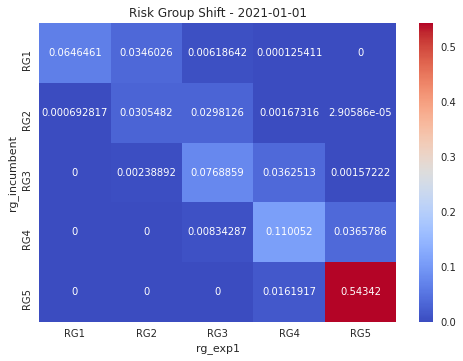

In [17]:
get_transition_plot(df_, "rg_incumbent", "rg_exp1")

In [18]:
invar_pct = []
invar_pct_active = []
ap = []
auc = []
for a in tqdm(np.linspace(0,1)):
    df_["pred_exp1"] = linear_interpolate(df_["pred_incumbent"],
                                          df_["pred_wo_ind"],
                                          a=a)
    df_["score_exp1"] = mu.scale_scores(df_["pred_exp1"])
    df_["rg_exp1"] = get_risk_groups(df_["score_exp1"])
    pct = get_invariant_percentage(df_, "rg_incumbent", "rg_exp1")
    invar_pct.append(pct)
    
    df__ = df_[df_.is_active]
    pct = get_invariant_percentage(df__, "rg_incumbent", "rg_exp1")
    invar_pct_active.append(pct)
    
    report = mntr.get_pred_reports(df_, "target", ["score_exp1"], dropna=True)
    ap.append(report["ap"].item())
    auc.append(report["auc"].item())
    

invar_pct_pred = pd.DataFrame({"invar_tot": invar_pct,
                          "invar_active": invar_pct_active,
                          "ap": ap,
                          "auc": auc}, 
                         index=np.linspace(0,1))

100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


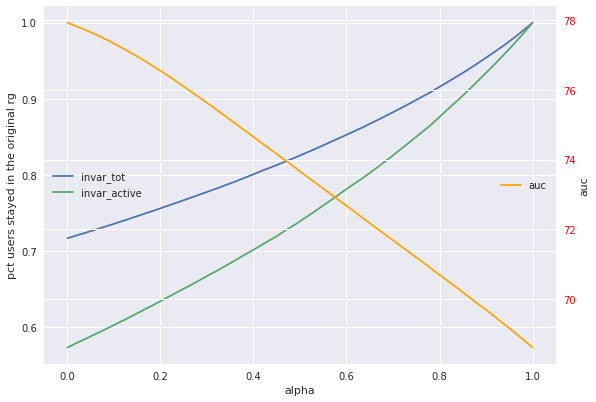

In [19]:
fig, ax1 = plt.subplots()

ax1.plot(invar_pct_pred.index, invar_pct_pred.invar_tot, label="invar_tot")
ax1.plot(invar_pct_pred.index, invar_pct_pred.invar_active, label="invar_active")

ax2 = ax1.twinx()
ax2.plot(invar_pct_pred.index, invar_pct_pred.auc, label="auc", color="orange")
ax2.tick_params(axis='y', labelcolor="red")
fig.tight_layout()

ax1.set_xlabel("alpha")
ax1.set_ylabel("pct users stayed in the original rg")
ax2.set_ylabel("auc")
ax1.legend(loc='center left')
ax2.legend(loc='right')
plt.show()

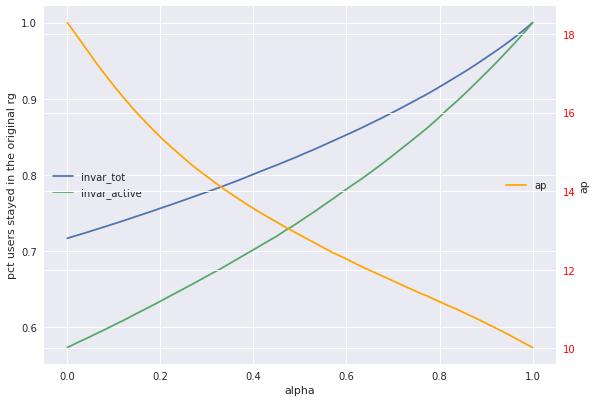

In [34]:
fig, ax1 = plt.subplots()

ax1.plot(invar_pct_pred.index, invar_pct_pred.invar_tot, label="invar_tot")
ax1.plot(invar_pct_pred.index, invar_pct_pred.invar_active, label="invar_active")

ax2 = ax1.twinx()
ax2.plot(invar_pct_pred.index, invar_pct_pred.ap, label="ap", color="orange")
ax2.tick_params(axis='y', labelcolor="red")
fig.tight_layout()

ax1.set_xlabel("alpha")
ax1.set_ylabel("pct users stayed in the original rg")
ax2.set_ylabel("ap")
ax1.legend(loc='center left')
ax2.legend(loc='right')
plt.show()

#### Exp2 - smooth over score

In [21]:
a = 0.5
df_["score_exp2"] = linear_interpolate(df_["score_incumbent"],
                                       df_["score_wo_ind"],
                                       a=a)
df_["rg_exp2"] = get_risk_groups(df_["score_exp2"])

nr accounts:  653852
ratio of users kept their RG:  0.8489474682344016


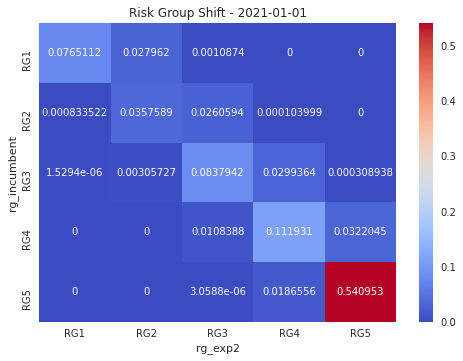

In [22]:
get_transition_plot(df_, "rg_incumbent", "rg_exp2")

In [23]:
invar_pct = []
invar_pct_active = []
ap = []
auc = []
for a in tqdm(np.linspace(0,1)):
    df_["score_exp2"] = linear_interpolate(df_["score_incumbent"],
                                       df_["score_wo_ind"],
                                       a=a)
    df_["rg_exp2"] = get_risk_groups(df_["score_exp2"])
    
    pct = get_invariant_percentage(df_, "rg_incumbent", "rg_exp2")
    invar_pct.append(pct)
    
    df__ = df_[df_.is_active]
    pct = get_invariant_percentage(df__, "rg_incumbent", "rg_exp2")
    invar_pct_active.append(pct)

    report = mntr.get_pred_reports(df_, "target", ["score_exp2"], dropna=True)
    ap.append(report["ap"].item())
    auc.append(report["auc"].item())
    

invar_pct_score = pd.DataFrame({"invar_tot": invar_pct,
                          "invar_active": invar_pct_active,
                          "ap": ap,
                          "auc": auc}, 
                         index=np.linspace(0,1))


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


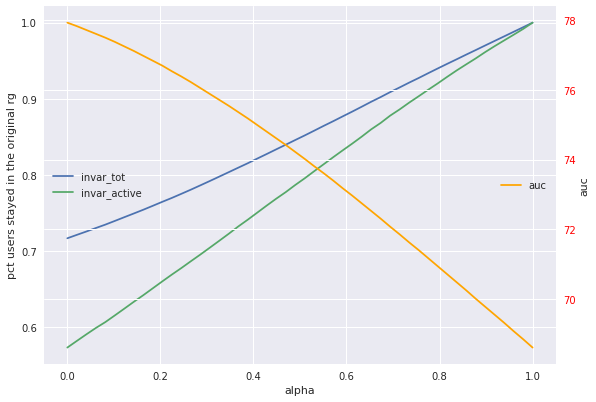

In [24]:
fig, ax1 = plt.subplots()

ax1.plot(invar_pct_score.index, invar_pct_score.invar_tot, label="invar_tot")
ax1.plot(invar_pct_score.index, invar_pct_score.invar_active, label="invar_active")

ax2 = ax1.twinx()
ax2.plot(invar_pct_score.index, invar_pct_score.auc, label="auc", color="orange")
ax2.tick_params(axis='y', labelcolor="red")
fig.tight_layout()

ax1.set_xlabel("alpha")
ax1.set_ylabel("pct users stayed in the original rg")
ax2.set_ylabel("auc")
ax1.legend(loc='center left')
ax2.legend(loc='right')
plt.show()

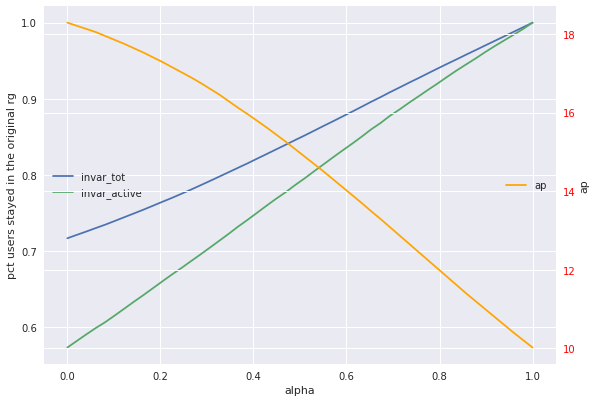

In [35]:
fig, ax1 = plt.subplots()

ax1.plot(invar_pct_score.index, invar_pct_score.invar_tot, label="invar_tot")
ax1.plot(invar_pct_score.index, invar_pct_score.invar_active, label="invar_active")

ax2 = ax1.twinx()
ax2.plot(invar_pct_score.index, invar_pct_score.ap, label="ap", color="orange")
ax2.tick_params(axis='y', labelcolor="red")
fig.tight_layout()

ax1.set_xlabel("alpha")
ax1.set_ylabel("pct users stayed in the original rg")
ax2.set_ylabel("ap")
ax1.legend(loc='center left')
ax2.legend(loc='right')
plt.show()

#### Exp3 - Non-linear transformation of scores - swaps
---

#### v1 - max interpolation
* Take the maximum of the `incumbent` and `refitted` model.
* Intuition: only allowing score/risk increase by allowing RG to go up.
    * allow user riskiness to drop
    * and hold the RG of those whose riskiness went down
    * This is on the conservative side of thinking.. but not really fair

nr accounts:  653852
ratio of users kept their RG:  0.78803154230621


,auc,ap,ks
score_incumbent,68.62,10.02,23.51
score_exp3,77.02,18.15,37.72
score_wo_ind,77.92,18.29,39.35


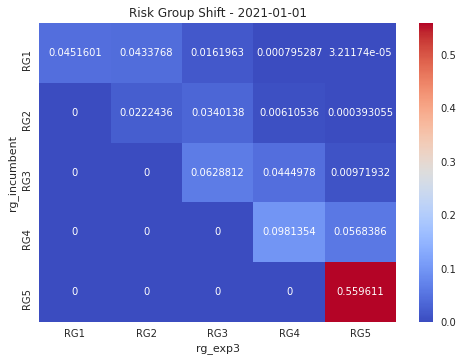

In [37]:
df_["score_exp3"] = df_[["score_incumbent", "score_wo_ind"]].max(axis=1)
df_["rg_exp3"] = get_risk_groups(df_["score_exp3"]) # ...okay same as maxing the rg..but this is cleaner
    
get_transition_plot(df_, "rg_incumbent", "rg_exp3")
report = mntr.get_pred_reports(df_, "target", ["score_incumbent", "score_exp3", "score_wo_ind"], dropna=True)
report

#### Exp 4
#### v2 - min interpolation 

* Take the minimum of the `incumbent` and `refitted` model.
* Intuition: only allowing score/risk reduction by allowing RG to go down.
    * allow user riskiness to improve
    * and hold the RG of those whose riskiness went up
    * more on the user experience side of the equation

nr accounts:  653852
ratio of users kept their RG:  0.9288875770051939


,auc,ap,ks
score_incumbent,68.62,10.02,23.51
score_exp4,70.31,10.95,25.91
score_wo_ind,77.92,18.29,39.35


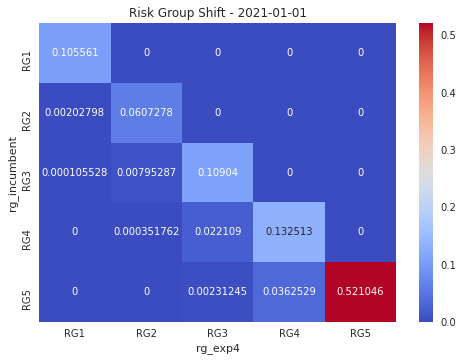

In [36]:
df_["score_exp4"] = df_[["score_incumbent", "score_wo_ind"]].min(axis=1)
df_["rg_exp4"] = get_risk_groups(df_["score_exp4"]) # ...okay same as maxing the rg..but this is cleaner
    
get_transition_plot(df_, "rg_incumbent", "rg_exp4")
report = mntr.get_pred_reports(df_, "target", ["score_incumbent", "score_exp4", "score_wo_ind"], dropna=True)
report

#### Exp 5
#### v3 - Non-linearly shrinking the Score shifts.

How can we do the limit RG shift by shrinking the score?

for example: take a square root

nr accounts:  653852
ratio of users kept their RG:  0.9477343496693441


,auc,ap,ks
score_incumbent,68.62,10.02,23.51
score_exp5,70.19,11.31,25.27
score_wo_ind,77.92,18.29,39.35


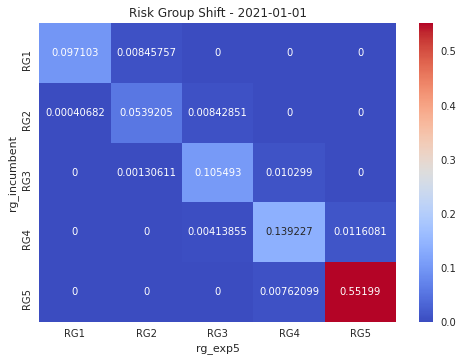

In [40]:
abs_diff = (df_["score_wo_ind"] - df_["score_incumbent"]).abs()
sign = np.sign(df_["score_diff_"])
df_["score_exp5"] = sign * np.sqrt(abs_diff) + df_["score_incumbent"]
df_["rg_exp5"] = get_risk_groups(df_["score_exp5"])

get_transition_plot(df_, "rg_incumbent", "rg_exp5")
report = mntr.get_pred_reports(df_, "target", ["score_incumbent", "score_exp5", "score_wo_ind"], dropna=True)
report

#### Exp 6
#### v4 - "Reverse Curving"

We used to curve test scores by:
* take a score between 0 - 100
* sqrt
* multiply by 10.

May be we should do something like this:
* map score different to 0-100 range
* divide by 10
* square
* map back to the original score diff

which is same as
* map score diff to 0-1
* square
* map back

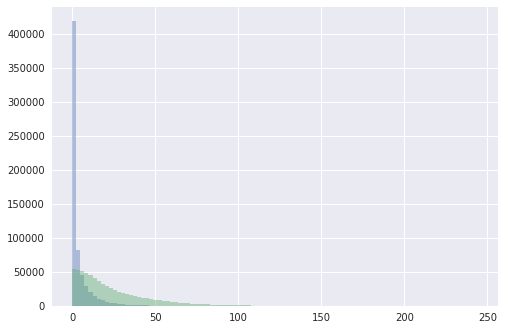

In [93]:
# get score diff
abs_diff = (df_["score_wo_ind"] - df_["score_incumbent"]).abs()
abs_diff_orig = abs_diff.copy()
sign = np.sign(df_["score_diff_"])

# map abs_diff to 0-1
max_diff, min_diff = max(abs_diff), min(abs_diff)
diff_range = max_diff - min_diff
abs_diff = (abs_diff - min_diff) / diff_range
assert abs_diff.between(0,1).all()

abs_diff = abs_diff ** 2   # square
abs_diff = abs_diff * diff_range + min_diff  # map back

abs_diff.hist(bins=100, alpha=0.4, label="reverse curved")
abs_diff_orig.hist(bins=100, alpha=0.4, label="original")
plt.show()

# add diff to score_incumbent to produce score_exp6
df_["score_exp6"] = sign * np.sqrt(abs_diff) + df_["score_incumbent"]
df_["rg_exp6"] = get_risk_groups(df_["score_exp6"])

nr accounts:  653852
ratio of users kept their RG:  0.9811562861320298


,auc,ap,ks
score_incumbent,68.62,10.02,23.51
score_exp6,69.36,10.63,24.34
score_wo_ind,77.92,18.29,39.35


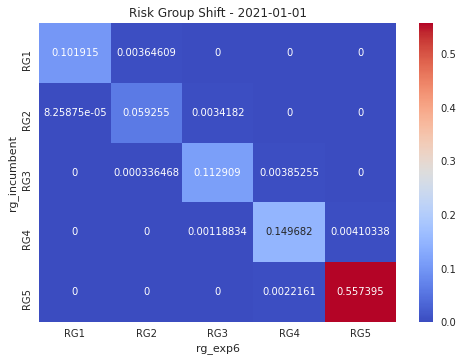

In [94]:
get_transition_plot(df_, "rg_incumbent", "rg_exp6")
report = mntr.get_pred_reports(df_, "target", ["score_incumbent", "score_exp6", "score_wo_ind"], dropna=True)
report

#### Get score summary table

In [47]:
# reconstruct experiment 1 and 2 with a = 0.5
a = 0.5
df_["pred_exp1"] = linear_interpolate(df_["pred_incumbent"],
                                      df_["pred_wo_ind"],
                                      a=a)
df_["score_exp1"] = mu.scale_scores(df_["pred_exp1"])
df_["rg_exp1"] = get_risk_groups(df_["score_exp1"])

a = 0.5
df_["score_exp2"] = linear_interpolate(df_["score_incumbent"],
                                       df_["score_wo_ind"],
                                       a=a)
df_["rg_exp2"] = get_risk_groups(df_["score_exp2"])

In [95]:
scores = ["score_incumbent", "score_exp1", "score_exp2", "score_exp3", 
          "score_exp4", "score_exp5", "score_exp6", "score_wo_ind"]
report = mntr.get_pred_reports(df_, "target", scores, dropna=True)

report

,auc,ap,ks
score_incumbent,68.62,10.02,23.51
score_exp1,73.67,12.88,31.14
score_exp2,74.12,14.98,31.19
score_exp3,77.02,18.15,37.72
score_exp4,70.31,10.95,25.91
score_exp5,70.19,11.31,25.27
score_exp6,69.36,10.63,24.34
score_wo_ind,77.92,18.29,39.35


In [96]:
rgs = ["rg_exp1", "rg_exp2", "rg_exp3", 
        "rg_exp4", "rg_exp5", "rg_exp6", "rg_wo_ind"]
inv_pct = {"rg_incumbent": 1.0}
for rg in rgs:
    pct = get_invariant_percentage(df_, "rg_incumbent", rg)
    inv_pct[rg] = pct

inv_pct = pd.Series(inv_pct).rename("pct_rg_unchanged").to_frame()
inv_pct["score_name"] = inv_pct.index.str.replace("rg_", "score_")

# merge with report
report = pd.merge(report, inv_pct, left_index=True, right_on="score_name")

In [97]:
report[["auc", "ap", "pct_rg_unchanged"]].sort_values("pct_rg_unchanged", ascending=False)

,auc,ap,pct_rg_unchanged
rg_incumbent,68.62,10.02,1.000000
rg_exp6,69.36,10.63,0.981156
rg_exp5,70.19,11.31,0.947734
rg_exp4,70.31,10.95,0.928888
rg_exp2,74.12,14.98,0.848947
rg_exp1,73.67,12.88,0.825552
rg_exp3,77.02,18.15,0.788032
rg_wo_ind,77.92,18.29,0.716919


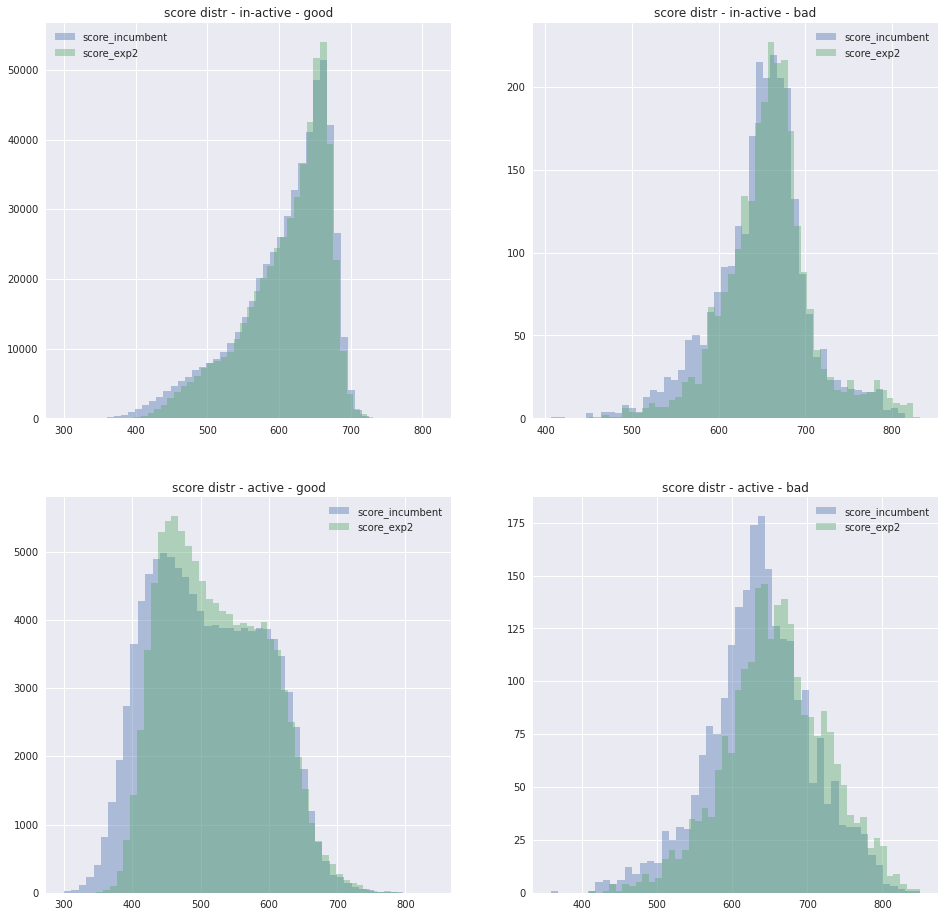

In [63]:
# linear interp of scores
plot_active_inactive(df_, "score_incumbent", "score_exp2")

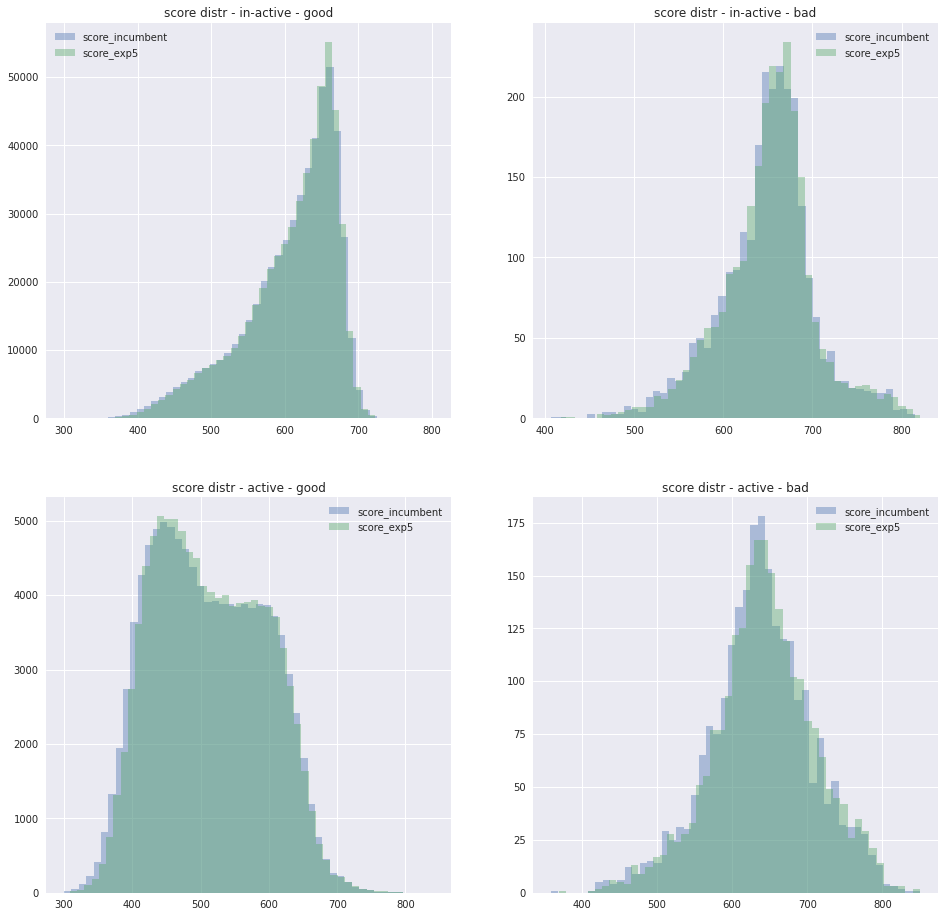

In [64]:
# sqrt
plot_active_inactive(df_, "score_incumbent", "score_exp5")

### Optimization Method for RG Segmentations
---

In [14]:
import pandas as pd
from scipy.optimize import minimize, Bounds, dual_annealing

In [13]:
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")].copy()

#### Global method: Dual Annealing

In [34]:
def get_risk_groups(serie, thresholds):
    thresh = sorted(list(set(list(thresholds)+[300, 850])))
    
    return pd.cut(serie.round(), thresh, 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)    

def risk_group_shift(rg1, rg2):
    return 1 - (rg1 == rg2).mean()

def obj_fn(thresholds):
    rg1 = df_["rg_incumbent"]
    rg2 = get_risk_groups(df_["score_wo_ind"], thresholds)
    return risk_group_shift(rg1, rg2)

In [54]:
%%time 
bounds = [[300, 500],
          [460, 560],
          [500, 600], 
          [600, 850]]
result = dual_annealing(obj_fn, bounds, maxiter=1000)

CPU times: user 1min 56s, sys: 29.8 ms, total: 1min 56s
Wall time: 1min 56s


In [55]:
result

     fun: 0.25880933299890496
 message: ['Maximum number of iteration reached']
    nfev: 8116
    nhev: 0
     nit: 1000
    njev: 23
  status: 0
 success: True
       x: array([499.12658763, 520.96006678, 565.28298415, 600.11277609])

In [56]:
obj_fn([474, 510, 560, 600])

0.28308088068859616

In [49]:
obj_fn([480, 512, 557, 600])

0.2765992915828047

In [52]:
obj_fn([500, 524, 565, 600])

0.25864568740326555

In [57]:
obj_fn([500, 520, 565, 600])

0.2584912181961667

nr accounts:  653852
ratio of users kept their RG:  0.7415087818038333


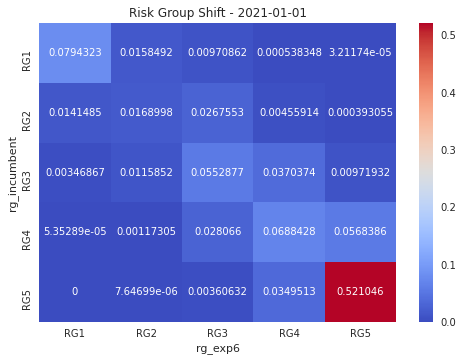

In [65]:
df_["rg_exp6"] = get_risk_groups(df_["score_wo_ind"], [500, 520, 565, 600])
get_transition_plot(df_, "rg_incumbent", "rg_exp6")

#### Local Methods

In [63]:
%%time
result = minimize(obj_fn, x0=(474, 510, 560, 600), method="Powell")

CPU times: user 3.46 s, sys: 122 µs, total: 3.46 s
Wall time: 3.46 s


In [64]:
result

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: 0.2573640518037721
 message: 'Optimization terminated successfully.'
    nfev: 237
     nit: 2
  status: 0
 success: True
       x: array([520.16010247, 508.40983005, 565.13748706, 598.40983005])

In [62]:
obj_fn([508, 520, 565, 600])

0.25740381615411434

nr accounts:  653852
ratio of users kept their RG:  0.7425961838458855


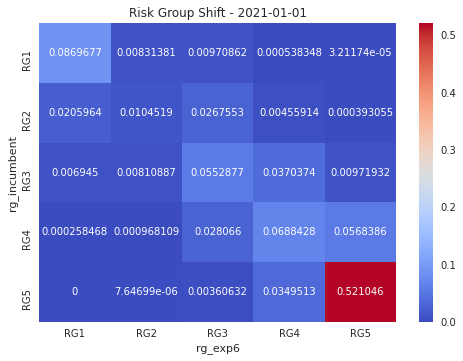

In [66]:
df_["rg_exp6"] = get_risk_groups(df_["score_wo_ind"], [508, 520, 565, 600])
get_transition_plot(df_, "rg_incumbent", "rg_exp6")